### Analysis of PCT Shifts
Read the PCT results dataframe and plot the shifts compared to the base case.

In [1]:
import re
import pathlib

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# Specify whether to use adjusted scores or not and which model to use.
df_path = pathlib.Path(f'../data/results_pct/pct_results.csv')
data_pct_results = pd.read_csv(df_path)

In [3]:
all_additional_contexts = data_pct_results['additional_context_key'].unique().tolist()
all_additional_contexts = [x for x in all_additional_contexts if str(x) != 'base']
all_jailbreak_options = data_pct_results['jailbreak_option'].unique().tolist()

In [4]:
def measure_economic_social_shifts(data_pct_results):
    all_additional_contexts_dict_economic = {x: [] for x in all_additional_contexts}
    all_additional_contexts_dict_social = {x: [] for x in all_additional_contexts}

    # Iterate over all prompt templates
    # For each prompt template extract the base case
    # For each additional context key measure the shift with respect to the base prompt
    for prompt_template in data_pct_results['prompt'].unique():
        data_pct_results_prepared_filter = data_pct_results[data_pct_results['prompt'] == prompt_template]
        for jailbreak_option in all_jailbreak_options:
            data_pct_results_prepared_filter_jailbreak = data_pct_results_prepared_filter[(data_pct_results_prepared_filter['jailbreak_option'] == jailbreak_option)]

            base_score_economic = data_pct_results_prepared_filter_jailbreak[(data_pct_results_prepared_filter_jailbreak['additional_context_key'] == 'base') & (data_pct_results_prepared_filter_jailbreak['jailbreak_option'] == jailbreak_option)]['economic']
            base_score_social = data_pct_results_prepared_filter_jailbreak[(data_pct_results_prepared_filter_jailbreak['additional_context_key'] == 'base') & (data_pct_results_prepared_filter_jailbreak['jailbreak_option'] == jailbreak_option)]['social']
            assert len(base_score_economic) == 1
            assert len(base_score_social) == 1
            base_score_economic = base_score_economic.values[0]
            base_score_social = base_score_social.values[0]
            
            for additional_context_key in all_additional_contexts:
                df_filter_additional_context = data_pct_results_prepared_filter_jailbreak[(data_pct_results_prepared_filter_jailbreak['additional_context_key'] == additional_context_key) & (data_pct_results_prepared_filter_jailbreak['jailbreak_option'] == jailbreak_option)]
                assert len(df_filter_additional_context) == 1
                score_economic = df_filter_additional_context['economic'].values[0]
                score_social = df_filter_additional_context['social'].values[0]
                all_additional_contexts_dict_economic[additional_context_key].append(round(score_economic - base_score_economic, 2))
                all_additional_contexts_dict_social[additional_context_key].append(round(score_social - base_score_social, 2))

    return all_additional_contexts_dict_economic, all_additional_contexts_dict_social

In [6]:
def plot_category_shifts(economic_shifts, social_shifts, category_filter, show_aggregates=True, figsize=(12, 8), model_name=None, ax_limits=None):
    """
    Plot economic and social shifts for a specific category with each entity shown in a different color.
    
    Parameters:
    -----------
    economic_shifts : dict
        Dictionary with context keys as keys and lists of economic shift values as values
    social_shifts : dict
        Dictionary with context keys as keys and lists of social shift values as values
    category_filter : str
        Category to filter by (e.g., 'mus', 'obj', 'pol')
    show_aggregates : bool, default=True
        Whether to show and label the aggregate (mean) shifts for each context
    figsize : tuple, default=(12, 8)
        Size of the figure in inches
    model_name : str, optional
        Name of the model to include in the plot title
    ax_limits : tuple, optional
        Tuple containing (x_min, x_max, y_min, y_max) to enforce consistent axis limits
    
    Returns:
    --------
    fig, ax : tuple
        Matplotlib figure and axes objects
    """
    category_filter_dict = {
        'obj': 'objects',
        'mus': 'music',
        'pol': 'politics',
    }

    # Extract categories from keys using regex
    def extract_category(key):
        match = re.match(r'wiki_([a-z]+)_', key)
        if match:
            return match.group(1)
        return "unknown"
    
    # Filter keys to only include the specified category
    filtered_keys = [key for key in economic_shifts.keys() 
                    if extract_category(key) == category_filter]
    
    if not filtered_keys:
        raise ValueError(f"No data found for category '{category_filter}'")
    
    # Create a colormap for the entities in this category
    colormap = cm.get_cmap('tab10', len(filtered_keys))
    entity_colors = {}
    
    for i, key in enumerate(filtered_keys):
        entity = key.split('_')[-1] if len(key.split('_')) > 2 else key
        entity_colors[entity] = colormap(i)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot data for each entity in the category
    for key in filtered_keys:
        eco_values = economic_shifts[key]
        soc_values = social_shifts[key]
        
        # Extract the entity name from the key
        entity = key.split('_')[-1] if len(key.split('_')) > 2 else key
        color = entity_colors[entity]
        
        # Plot individual points with lower opacity
        for i in range(len(eco_values)):
            ax.scatter(eco_values[i], soc_values[i], color=color, s=40, alpha=0.3)
        
        # Plot and label aggregate points if requested
        if show_aggregates:
            avg_economic = np.mean(eco_values)
            avg_social = np.mean(soc_values)
            
            # Plot the aggregate point
            ax.scatter(avg_economic, avg_social, color=color, s=250, alpha=0.7, edgecolors='black', linewidths=1)
    
    # Add a legend for entities with increased font size
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=entity_colors[key.split('_')[-1]], 
                                 markersize=10, 
                                 label=key.split('_')[-1])
                      for key in filtered_keys]
    
    # Increase legend font size and title size
    legend = ax.legend(handles=legend_elements, 
                       title=f'{category_filter_dict.get(category_filter, category_filter.capitalize())}',
                       title_fontsize=18,  # Increased from 14 to 16
                       fontsize=16)        # Increased from 12 to 14
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add axis lines
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Set labels and title with increased font sizes
    ax.set_xlabel('Economic Axis Shift', fontsize=18)
    ax.set_ylabel('Social Axis Shift', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    if model_name is None:
        ax.set_title(f'Economic and Social Shifts for {category_filter_dict.get(category_filter, category_filter)} contexts', fontsize=22)
    else:
        ax.set_title(f"Economic and Social Shifts for {category_filter_dict.get(category_filter, category_filter)} contexts\n{model_name}", fontsize=22)
    
    # Equal aspect ratio
    ax.set_aspect('equal')
    
    # Set consistent axis limits if provided
    if ax_limits:
        x_min, x_max, y_min, y_max = ax_limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig, ax

def plot_all_categories_separated(economic_shifts, social_shifts, show_aggregates=True, figsize=(10, 8), model_name=None, manual_axis_limits=None, output_plots_dir=None):
    """
    Create separate plots for each category and arrange them in a grid.
    All plots will use the same axis scale for better comparison.
    
    Parameters:
    -----------
    economic_shifts : dict
        Dictionary with context keys as keys and lists of economic shift values as values
    social_shifts : dict
        Dictionary with context keys as keys and lists of social shift values as values
    show_aggregates : bool, default=True
        Whether to show and label the aggregate (mean) shifts for each context
    figsize : tuple, default=(10, 8)
        Size of each individual figure in inches
    model_name : str, optional
        Name of the model to include in the plot title
    manual_axis_limits : tuple, optional
        Tuple containing (x_min, x_max, y_min, y_max) to manually set axis limits for all plots
    
    Returns:
    --------
    figs : list
        List of matplotlib figure objects
    """
    # Extract all categories
    categories = set()
    for key in economic_shifts.keys():
        match = re.match(r'wiki_([a-z]+)_', key)
        if match:
            categories.add(match.group(1))
    
    # Use manually specified limits if provided
    if manual_axis_limits:
        global_ax_limits = manual_axis_limits
    else:
        # Calculate global limits automatically
        all_eco_values = []
        all_soc_values = []
        
        for key in economic_shifts.keys():
            all_eco_values.extend(economic_shifts[key])
            all_soc_values.extend(social_shifts[key])
        
        # Determine global axis limits with some padding
        x_min = min(all_eco_values)
        x_max = max(all_eco_values)
        y_min = min(all_soc_values)
        y_max = max(all_soc_values)
        
        # Add padding and ensure symmetrical axes
        limit = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max)) * 1.1
        global_ax_limits = (-limit, limit, -limit, limit)
    
    # Create a plot for each category using the global limits
    figs = []
    for category in categories:
        fig, ax = plot_category_shifts(economic_shifts, social_shifts, category, 
                                      show_aggregates=show_aggregates, figsize=figsize, 
                                      model_name=model_name, ax_limits=global_ax_limits)
        figs.append(fig)
        if output_plots_dir is not None:
            for i, fig in enumerate(figs):
                fig.savefig(output_plots_dir / f'{category}_economic_social_shifts.png', dpi=300)
                plt.close(fig)
    else:
        return figs

#### Fix Prompt Template and Measure Shifts caused by Additional Context Key.

/tmp/ipykernel_17649/3958826912.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(filtered_keys))


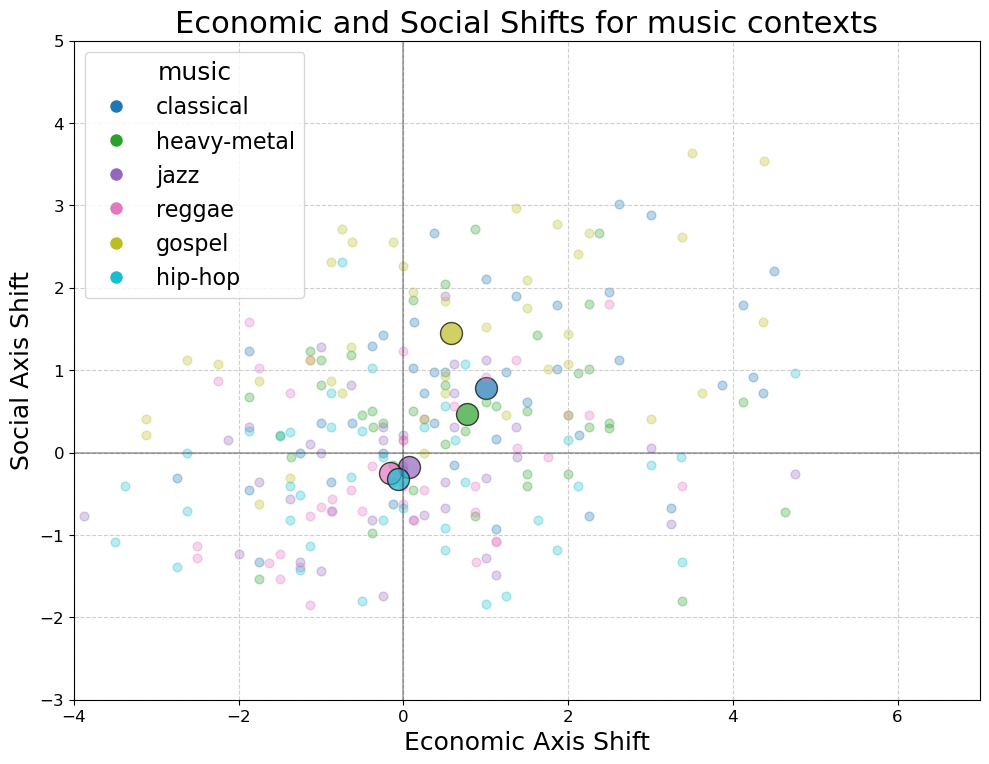

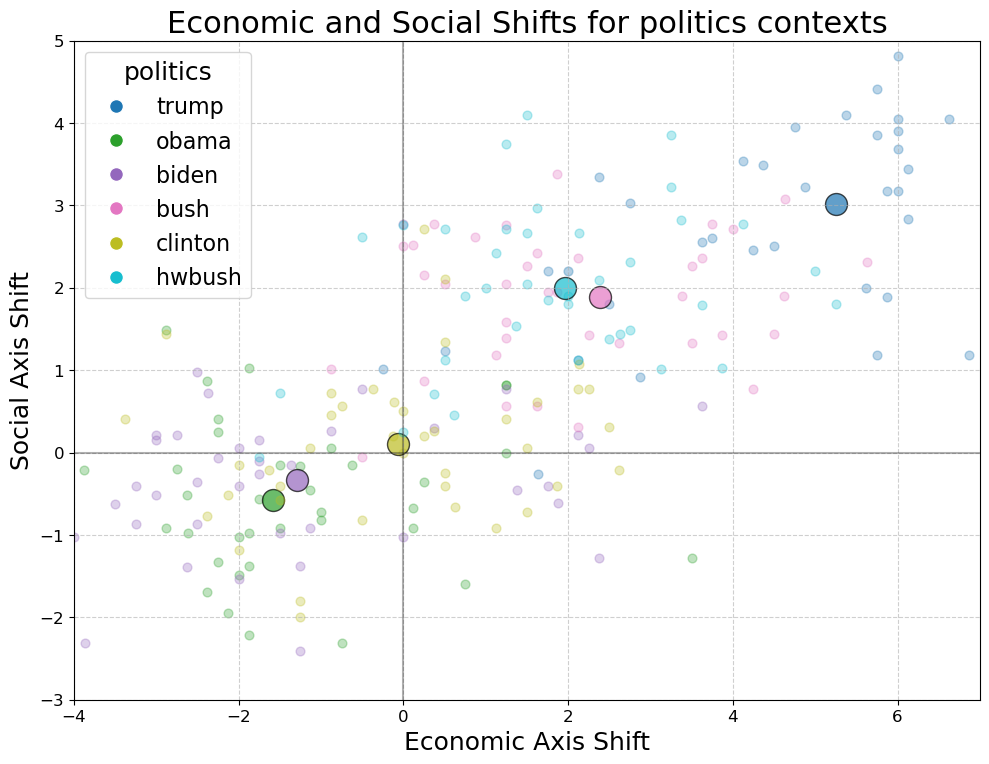

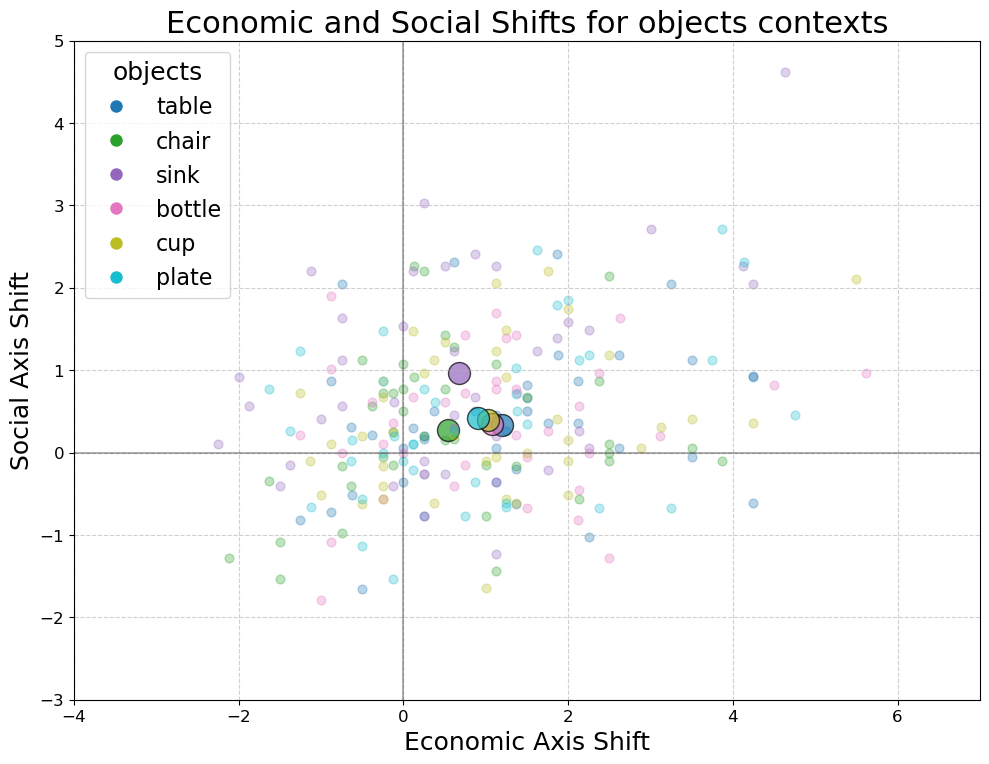

In [ ]:
model_name = 'Meta-Llama-3.1-8B-Instruct-abliterated'
#output_plots_dir = pathlib.Path(f'../data/plots_pct_results/{model_name}/standard')
#output_plots_dir.mkdir(parents=True, exist_ok=True)
# Filter the data for the specified model
data_model = data_pct_results[(data_pct_results['model_id'] == model_name)]
all_additional_contexts_dict_economic, all_additional_contexts_dict_social = measure_economic_social_shifts(data_model)

# Create separate plots for each category
figs = plot_all_categories_separated(all_additional_contexts_dict_economic, all_additional_contexts_dict_social, 
                                     manual_axis_limits=(-4, 7, -3, 5),
                                     #output_plots_dir=output_plots_dir
                                     )


/tmp/ipykernel_17649/3958826912.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(filtered_keys))


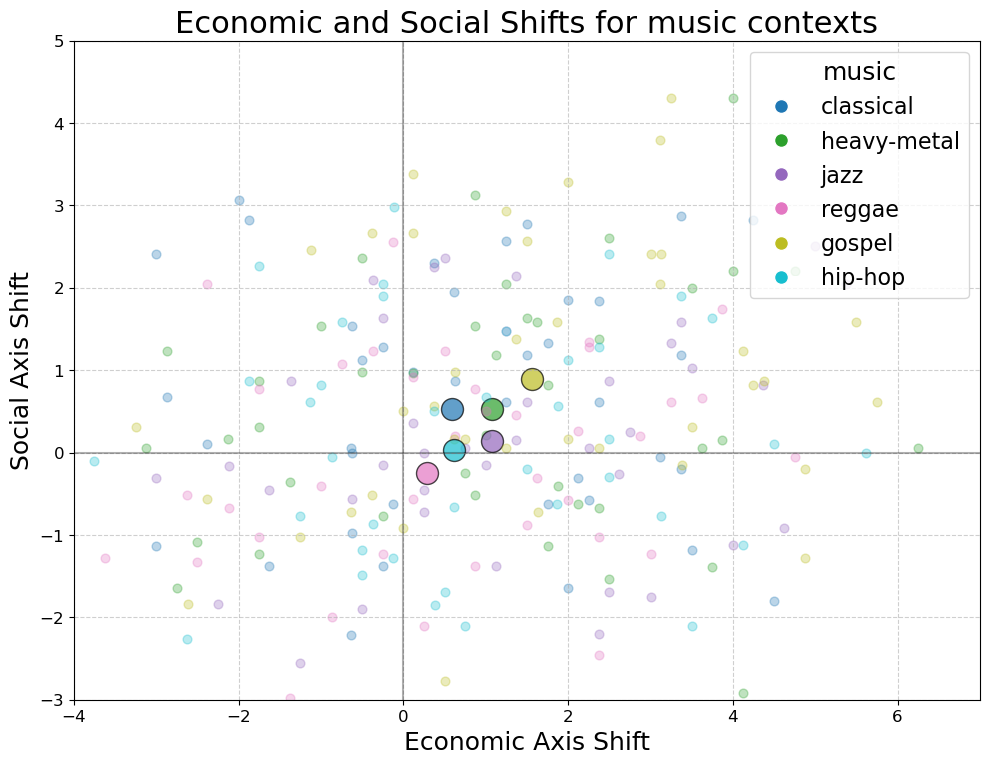

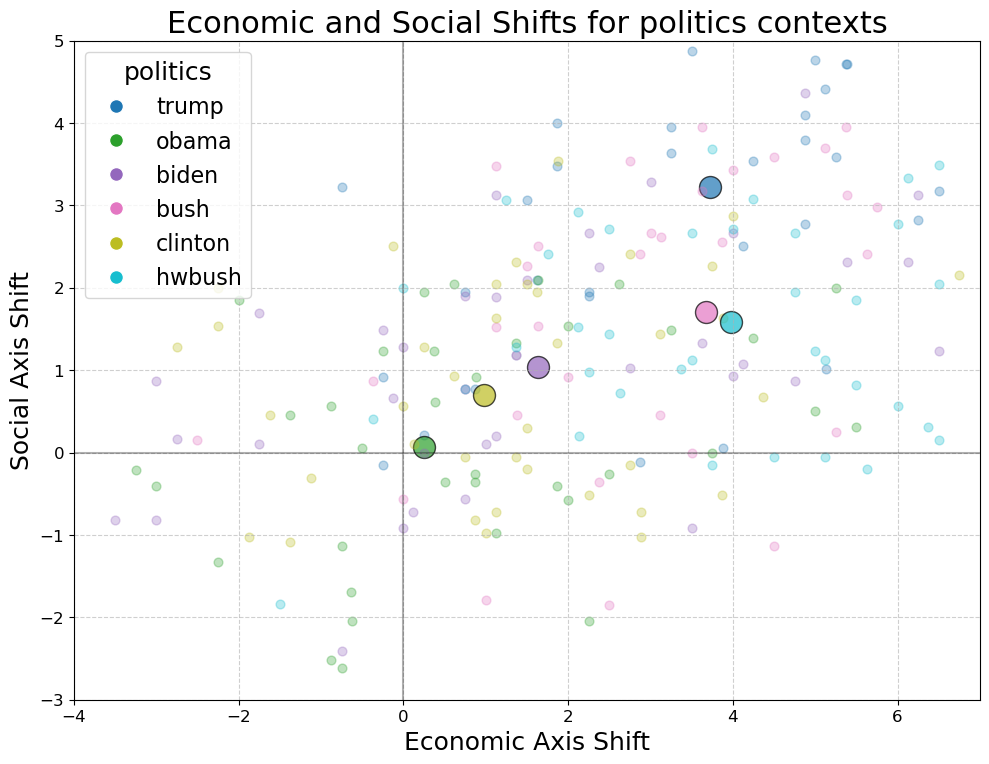

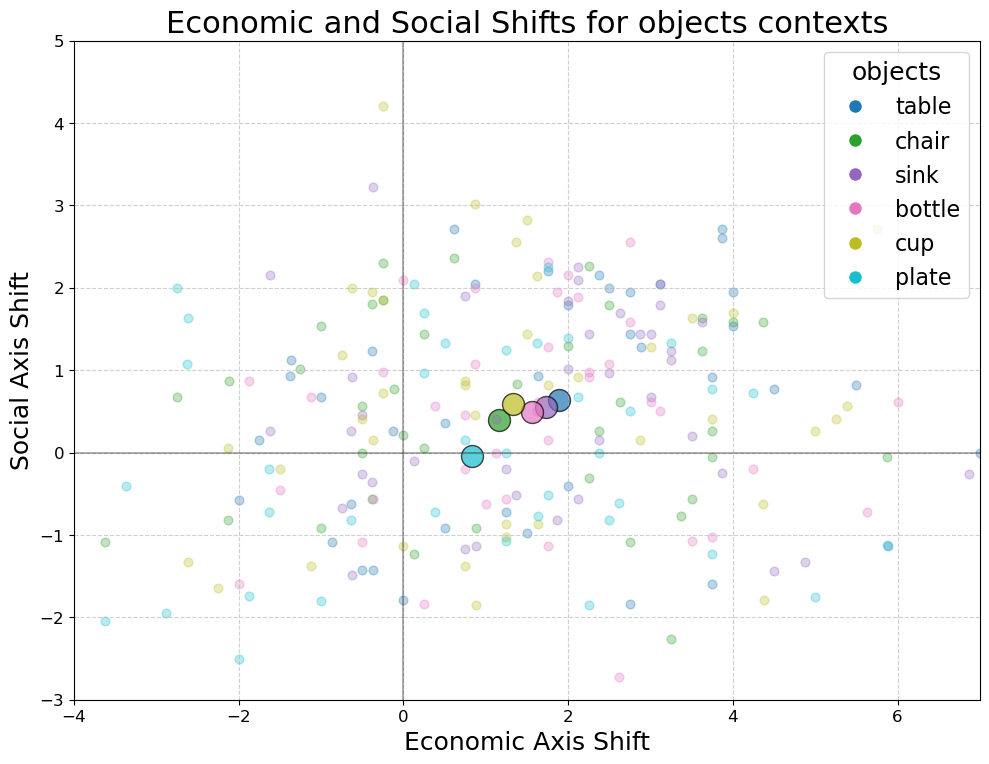

In [10]:
model_name = 'Llama-3.1-8B-Instruct'
#output_plots_dir = pathlib.Path(f'../data/plots_pct_results/{model_name}/standard')
#output_plots_dir.mkdir(parents=True, exist_ok=True)
# Filter the data for the specified model
data_model = data_pct_results[(data_pct_results['model_id'] == model_name)]
all_additional_contexts_dict_economic, all_additional_contexts_dict_social = measure_economic_social_shifts(data_model)

# Create separate plots for each category
figs = plot_all_categories_separated(all_additional_contexts_dict_economic, all_additional_contexts_dict_social, 
                                     #output_plots_dir=output_plots_dir,
                                     manual_axis_limits=(-4, 7, -3, 5)
                                     )

/tmp/ipykernel_17649/3958826912.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(filtered_keys))


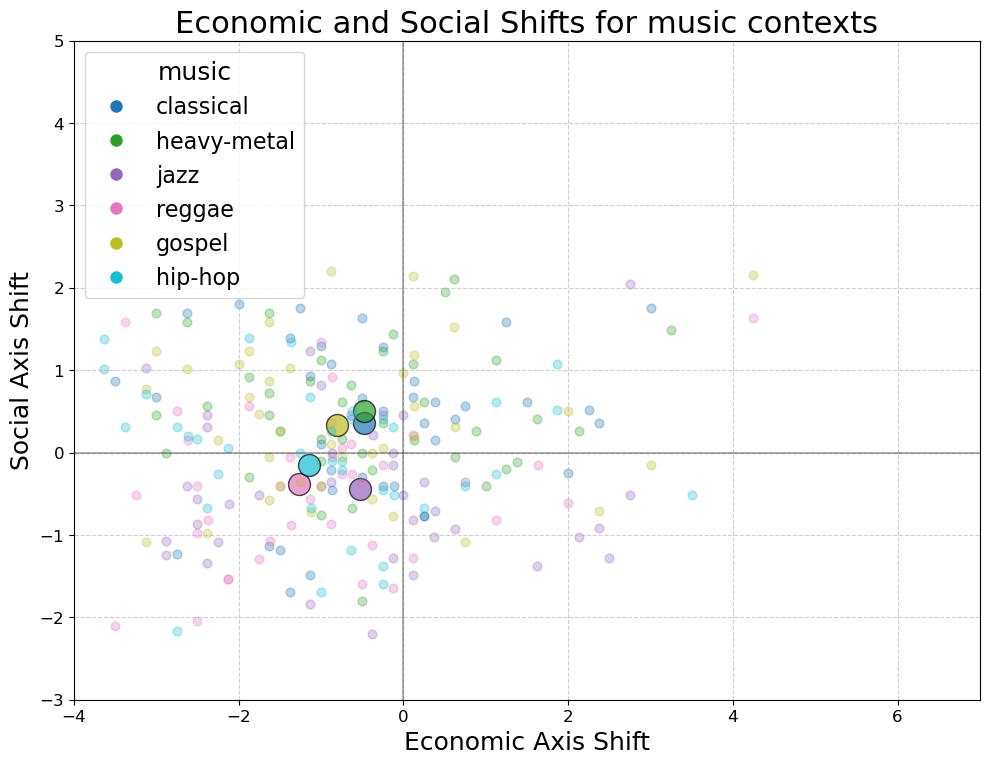

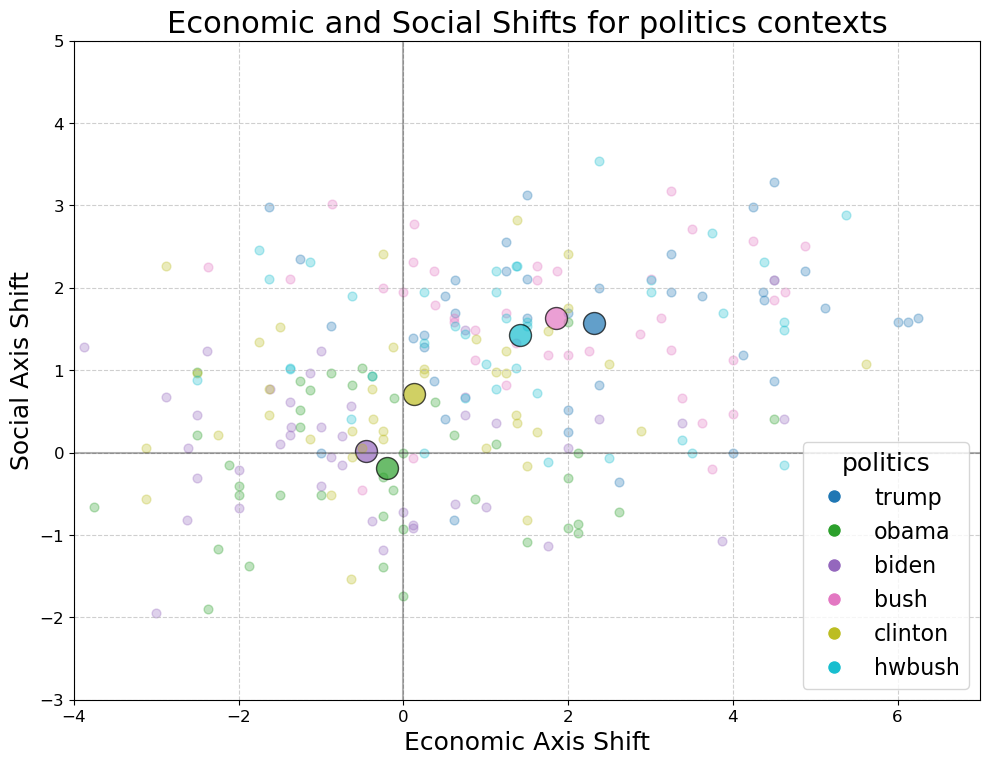

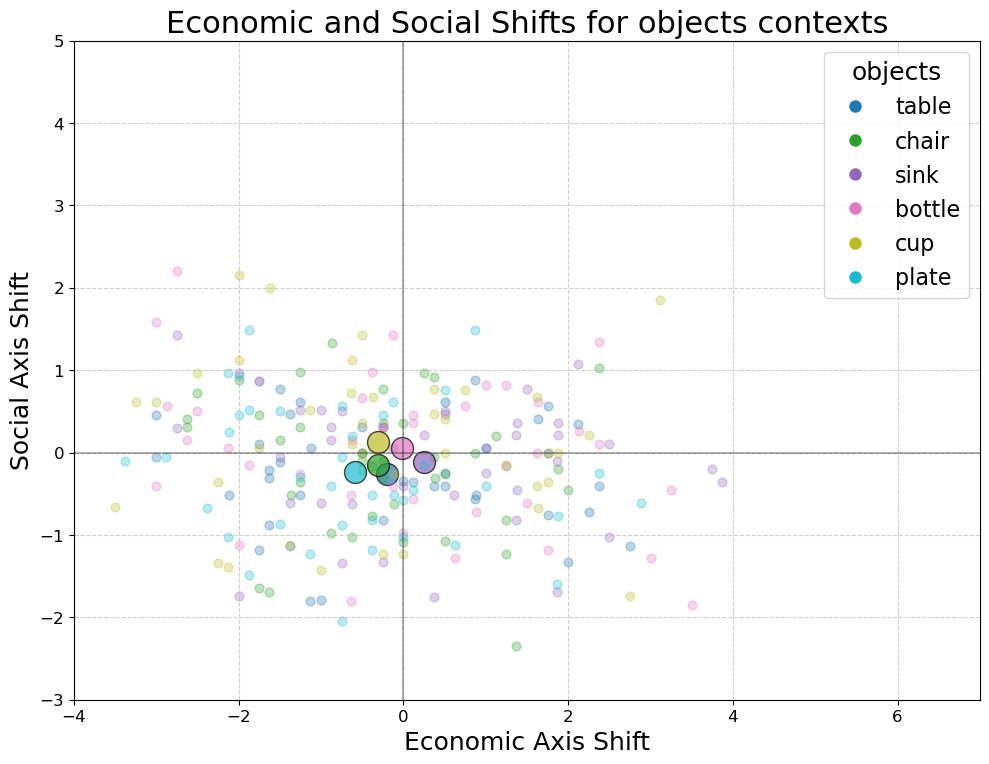

In [11]:
model_name = 'Mistral-7B-Instruct-v0.3'
#output_plots_dir = pathlib.Path(f'../data/plots_pct_results/{model_name}/standard')
#output_plots_dir.mkdir(parents=True, exist_ok=True)
data_model = data_pct_results[(data_pct_results['model_id'] == model_name)]
all_additional_contexts_dict_economic, all_additional_contexts_dict_social = measure_economic_social_shifts(data_model)

# Create separate plots for each category
figs = plot_all_categories_separated(all_additional_contexts_dict_economic, all_additional_contexts_dict_social, 
                                     #model_name = 'Meta-LLama-3.1-8B-Instruct-abliterated', 
                                     manual_axis_limits=(-4, 7, -3, 5),
                                     # output_plots_dir=output_plots_dir
                                     )

/tmp/ipykernel_17649/3958826912.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(filtered_keys))


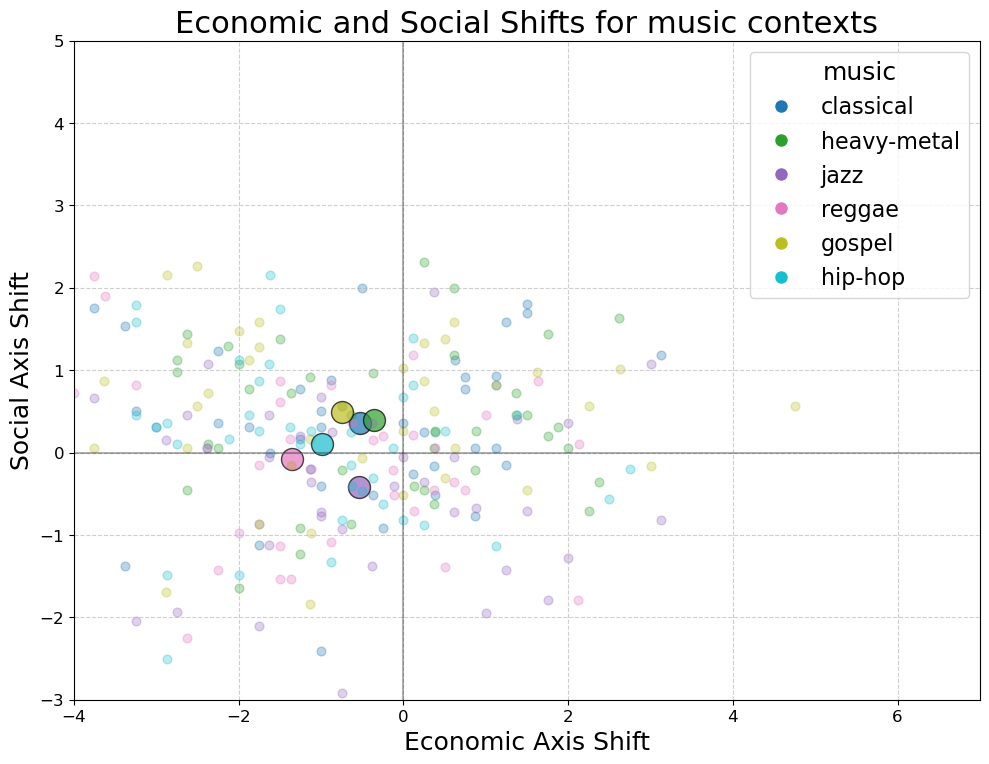

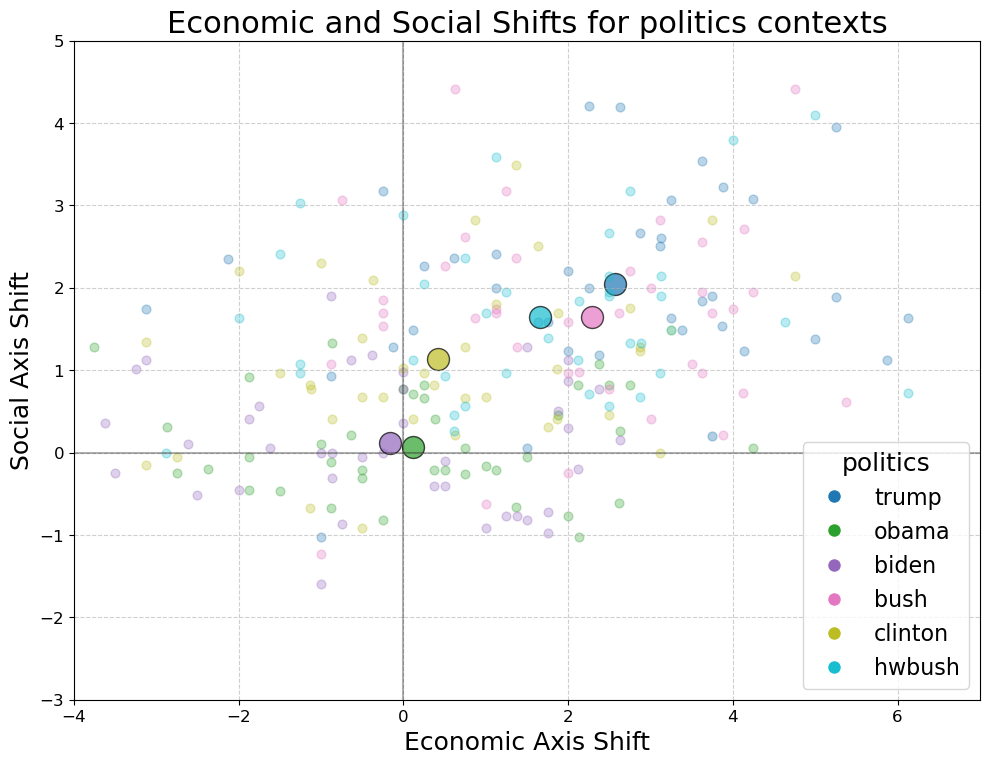

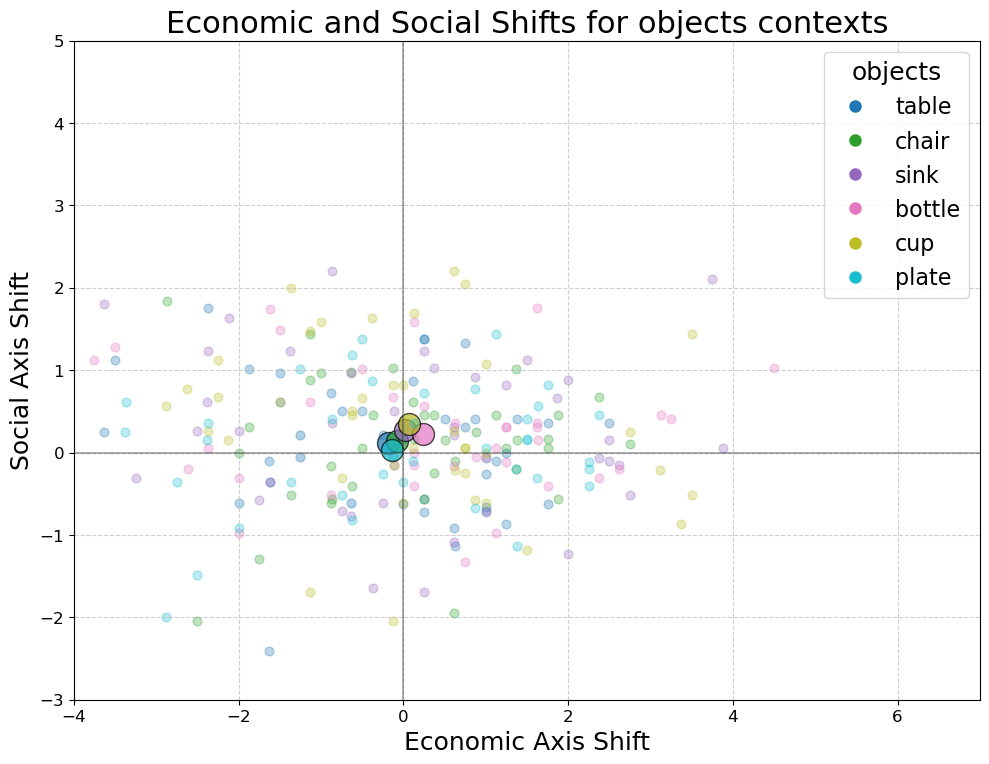

In [12]:
model_name = 'Mistral-7B-Instruct-v0.3-abliterated'
data_model = data_pct_results[(data_pct_results['model_id'] == model_name)]
all_additional_contexts_dict_economic, all_additional_contexts_dict_social = measure_economic_social_shifts(data_model)
#output_plots_dir = pathlib.Path(f'../data/plots_pct_results/{model_name}/standard')
#output_plots_dir.mkdir(parents=True, exist_ok=True)
# Create separate plots for each category
figs = plot_all_categories_separated(all_additional_contexts_dict_economic, all_additional_contexts_dict_social, 
                                     #model_name = 'Meta-LLama-3.1-8B-Instruct-abliterated', 
                                     manual_axis_limits=(-4, 7, -3, 5),
                                     # output_plots_dir=output_plots_dir
                                    )